# Topic Modeling for Narrative Generation

This notebook is part of a master's thesis project in Digital Interaction Design at Politecnico di Milano, by Federico Denni.

In [1]:
from IPython.display import clear_output
!pip3 install --upgrade pip
!pip install torchaudio==2.2.2
!pip install -U torch torchvision
!pip install bertopic
!pip install huggingface_hub
!pip install -q -U bitsandbytes
!pip install accelerate
!pip install xformers
!pip install adjustText
!pip install ipywidgets
!pip install spacy
!python -m spacy download xx_sent_ud_sm
clear_output()
print("all installed!")

all installed!


In order to use mistral we need to first identify ourselves using the hugginface token

In [2]:
from huggingface_hub import login, logout
from kaggle_secrets import UserSecretsClient  #import HF token from secrets

user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HUGGINFACE_TOKEN")
login(secret_value_0)

Let's now import the other necessary libraries

In [3]:
# Let's load the preprocessing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

Let's now import the csv file

In [4]:
try:
    #Change this directory for other dataset
    #if file not csv, use spaCy and pandas to convert it
    df = pd.read_csv('/kaggle/input/youtube-comments/Youtube Comments - Sheet1.csv', encoding="utf-8")
    #extract text column
    text_column = df[['text']]
    text_column.to_csv(r'/kaggle/working/just_text_column.csv',index=False, encoding="utf-8")
    df = pd.read_csv(r'/kaggle/working/just_text_column.csv',encoding="utf-8")
    df.head(10)
    
except FileNotFoundError:
      print("Error: file not found. Please upload the file or provide the correct path.")

We make sure the text that you want load is all in a column called "text", we will also eliminate whitespaces

In [5]:
#remove whitespaces
def remove_whitespaces(text):
    return " ".join(text.split())

df['text'] = df['text'].apply(remove_whitespaces)

# Display the first 12 rows of the updated DataFrame
df.head(12)

,text
0,Note that this was filmed in early December. I...
1,simone oh no
2,"Play fortunes foundation, then get back to me...."
3,At what point should emergency services be not...
4,Was this video supposed to release on what wou...
5,@@jaykaye594 i felt so accomplished with that ...
6,There are other Solitaire video games besides ...
7,This is what happened to me except it was the ...
8,"Doing very quick math, isn't that like 10 wins..."
9,Wake up. Solitaire. Breakfast. Solitaire. Get ...


Let's import the llm model (mistral) and hope it doesn't break

In [6]:
from torch import cuda

model_id = 'mistralai/Mistral-7B-Instruct-v0.1'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


Let's quantize so we don't burn anymore trees than necessary

In [7]:
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

# Mistral Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Mistral Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

print("quantized!")

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

quantized!


In [8]:
#Let's setup the role and pipeline of the model
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

Device set to use cuda:0


In [9]:
#Let's now test the model
prompt = "Scrivimi un haiku di 3 linee su una rana in un pozzo, il testo deve essere evocativo e creativo. Per favore, riporta solo il testo del poema"
res = generator(prompt)
print(res[0]["generated_text"])

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Scrivimi un haiku di 3 linee su una rana in un pozzo, il testo deve essere evocativo e creativo. Per favore, riporta solo il testo del poema.

La rana nel pozzo
Silenziosamente si muove
Natura's secret


Now let's compose the prompt, so that we instruct the llama2 model to do exactly as we want

In [10]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics, you follow the instruction closely.
<</SYS>>
"""

In [11]:
# Example prompt demonstrating the output we are looking for, maybe also we could add multiple language examples?
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- La carne, nello specifico il bovino, è il cibo con più alto impatto sull'ambiente.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.
- Mangiare la carne rappresentava il tuo status sociale di persona più ricca
- Nel futuro non potremmo mangiare più la carne come nel passato, perchè sarà visto socialmente male

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic with at most 5 words. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

In [12]:
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic with at most 5 words. Make sure you to only return the label and nothing more.
[/INST]
"""

There are two BERTopic-specific tags that are of interest, namely `[DOCUMENTS]` and `[KEYWORDS]`:

* `[DOCUMENTS]` contain the top 5 most relevant documents to the topic
* `[KEYWORDS]` contain the top 10 most relevant keywords to the topic as generated through c-TF-IDF

This template will be filled accordingly to each topic. And finally, we can combine this into our final prompt:

In [13]:
prompt = system_prompt + example_prompt + main_prompt

---

## BERTopic and Embeddings

let's prepare the embeddings, we will use a multilingual embedding model

In [14]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-m3") #multilanguage embedding 
embeddings = embedding_model.encode(df['text'], show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/472 [00:00<?, ?it/s]

In [15]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=5, n_components=5, min_dist=0.0, metric='cosine', random_state=42) #augment neighbors when you will have the correct amount of data
hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True) 

In [16]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)  #augment neighbors when you will have the correct amount of data

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.10/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.10/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisati

Let's now add additional rapresentations method so that we can have multiple points of view on our subject

In [17]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.5) #modify this value to get more different representative_docs

# Text generation with mistral
mistral = TextGeneration(generator, prompt=prompt)

# candidate_topics from research
candidate_topics = [
    'Family and Games', 
    'Rules of Games',
    'Games Collection',
    'Traditional Games',
    'Memories'
]

# All representation models
representation_model = {
    "Keywords": keybert,
    "Labels": mistral,
    "MMR": mmr,
}

Let's now train our topic model with BERTopic

In [19]:
from bertopic import BERTopic

topic_model = BERTopic(

  language="multilingual",
  zeroshot_topic_list = candidate_topics,
  zeroshot_min_similarity = 0.5,
  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(df['text'], embeddings)

#Show topics
freq = topic_model.get_topic_info() 
freq.to_csv(r'/kaggle/working/topics.csv', index=False)
freq.head(11)

2025-02-05 09:34:08,913 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-05 09:34:19,347 - BERTopic - Dimensionality - Completed ✓
2025-02-05 09:34:19,350 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-05 09:34:19,556 - BERTopic - Zeroshot Step 1 - Completed ✓
2025-02-05 09:34:37,551 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-05 09:34:39,693 - BERTopic - Cluster - Completed ✓
2025-02-05 09:34:39,694 - BERTopic - Zeroshot Step 2 - Combining topics from zero-shot topic modeling with topics from clustering...
2025-02-05 09:34:39,890 - BERTopic - Zeroshot Step 2 - Completed ✓
2025-02-05 09:34:39,891 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 8/8 [00:40<00:00,  5.08s/it]
2025-02-05 09:35:24,193 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Keywords,Labels,MMR,Representative_Docs
0,-1,5706,-1_the_it_to_you,"[the, it, to, you, is, and, of, that, this, in]","[symbols, cards, text, game, editing, card, go...","[\n""Card Game Design and Symbolism"", , , , , ,...","[it, to, you, uno, bro, edit, if, cards, just,...",[This is for everyone Just how you didn’t expe...
1,0,526,Family and Games,"[game, and, it, play, uno, my, lol, playing, w...","[playing, game, played, games, play, watching,...","[Family bonding through Uno, , , , , , , , , ]","[uno, my, lol, playing, thanks, family, fix, s...","[I'm a game developer, and I realized that my ..."
2,1,139,Rules of Games,"[rule, to, rules, game, the, of, theory, that,...","[symbols, rules, games, confusing, playing, ga...","[""Rule breaches in game design"", , , , , , , ,...","[rule, theory, you, symbols, games, and, golde...",[You should be careful with the symbols (Golde...
3,2,123,Games Collection,"[collezione, bellissima, la, che, bella, jack,...","[collezione, collection, bellissima, great, im...","[""Grande Jack Collection"", , , , , , , , , ]","[collezione, bellissima, jack, wow, expansion,...","[che bella collezione, Che bella collezione 😍😍..."
4,3,77,Traditional Games,"[game, games, it, the, in, play, just, uno, ca...","[playing, games, game, played, play, poker, ol...","[Card games and techniques, , , , , , , , , ]","[it, just, uno, card, technique, playing, or, ...","[​@@TheHistoryGuyChannel ​Yah, as I recall, th..."
5,4,433,Memories,"[facts, thank, song, thanks, nice, wow, me, yo...","[facts, honestly, interessante, interesant, th...","[Facts are appreciated and shared, , , , , , ,...","[song, nice, wow, belle, honestly, grazie, rel...","[Facts, Facts, FACTS]"
6,5,307,5_fr_bruh_frr_bruhv,"[fr, bruh, frr, bruhv, eccezionale, fcf, ft, b...","[fr, frr, ft, frrr, fe, hi, fcf, tho, bruh, fi...","[\n""Bruh"" language and its use, , , , , , , , , ]","[fr, eccezionale, fcf, bruv, maremma, fighissi...","[Fr, Fr, Fr]"
7,6,7791,6_the_to_of_and,"[the, to, of, and, you, is, in, it, that, this]","[playing, cards, game, card, games, this, ther...","[Card games without indexes, , , , , , , , , ]","[and, you, it, this, cards, video, jack, on, h...",[It seems that every country has a card game o...


In [21]:
topic_model.get_topic(1, full=True)["Keywords"] #let's check some of the keywords of the second item in the list

[('symbols', 0.5813743),
 ('rules', 0.5690445),
 ('games', 0.56332314),
 ('confusing', 0.55609846),
 ('playing', 0.53898454),
 ('game', 0.53696716),
 ('things', 0.50033665),
 ('should', 0.49743462),
 ('rule', 0.48999152),
 ('language', 0.4840576)]

In [22]:
mistral_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Labels"].values()]

mistral_labels = [label[0][0].strip().split("\n")[0] for label in topic_model.get_topics(full=True)["Labels"].values()]
topic_model.set_topic_labels(mistral_labels)

print(mistral_labels)    
topic_model.set_topic_labels(mistral_labels)

['"Card Game Design and Symbolism"', 'Family bonding through Uno', '"Rule breaches in game design"', '"Grande Jack Collection"', 'Card games and techniques', 'Facts are appreciated and shared', '"Bruh" language and its use', 'Card games without indexes']


---

### Visualize

Let's now visualize our topics (hoping that it works with this dataset)

In [23]:
from scipy.cluster import hierarchy as sch

linkage_function = lambda x: sch.linkage(x, 'ward', optimal_ordering=True)

# Extract hierarchical topics and their representations.
# A dataframe that contains a hierarchy of topics represented by their parents and their children.
hierarchical_topics: pd.DataFrame = topic_model.hierarchical_topics(df['text'], linkage_function=linkage_function)

fig = topic_model.visualize_hierarchy(
    # 'str' the orientation of the figure. Either 'left' or 'bottom'.
    orientation='left',

    # 'list[int]' a selection of topics to visualize.
    topics=None,

    # 'int' only select the top n most frequent topics to visualize.
    top_n_topics=None,

    # 'pd.DataFrame' a dataframe that contains a hierarchy of topics represented by their
    # parents and their children.
    # NOTE: The hierarchical topic names are only visualized if both 'topics' and 'top_n_topics' are not set.
    hierarchical_topics=hierarchical_topics,

    # Whether to use custom topic labels that were defined using 'topic_model.set_topic_labels'.
    custom_labels=True,

    width=1200,
    height=1000,
)

fig.update_layout(
    # Adjust left, right, top, bottom margin of the overall figure.
    margin=dict(l=20, r=20, t=60, b=20),

    title={
        'text': "Hierarchical structure of the topics",
        'y':0.975,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            size=22,
            color="#000000"
        )
    },
)

fig.show()

100%|██████████| 6/6 [00:00<00:00, 218.94it/s]


In [24]:
#topic_model.visualize_barchart()

import plotly.express as px

top_n_topics = 9
n_words = 5

# 'fig_barchart' is a plotly figure.
fig_barchart = topic_model.visualize_barchart(
    top_n_topics = top_n_topics,  # Only select the top n most frequent topics.
    n_words = n_words,            # Number of words to show in a topic.
    custom_labels=True,          # Whether to use custom topic labels that were defined using topic_model.set_topic_labels.
    title=f"Top {top_n_topics} topics visualized by the frequency of the top {n_words} words",
    width=300,
    height=300,
)

fig_barchart.update_layout(
    # Adjust left, right, top, bottom margin of the overall figure.
    margin=dict(l=20, r=50, t=80, b=20),

    plot_bgcolor='rgba(0,0,0,0)',         # Set background color (transparent in this example).

    title={
        'text': f"Top {top_n_topics} topics visualized by the frequency of the top {n_words} words/phrases",
        'y':0.975,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            family="Sans Serif",
            size=24,
            color="#000000"
        )
    },

    font=dict(
        family="Roboto",
        size=10,
        color="#000000"
    ),
)

color_sequence = px.colors.qualitative.Vivid  # Choose a color sequence.
fig_barchart.update_traces(marker_color=color_sequence)

# Show the updated figure
fig_barchart.show()

In [25]:
topic_model.visualize_heatmap(custom_labels=True)

In [26]:
df = pd.read_csv('/kaggle/input/youtube-comments/Youtube Comments - Sheet1.csv', encoding="utf-8")

titles = df['text']
documents = topic_model.visualize_documents(
    titles, 
    reduced_embeddings=reduced_embeddings,
    title=f"Topics visualized",
    hide_annotations=True, 
    hide_document_hover=False, 
    custom_labels=True,
)

documents.update_layout(
    # Adjust left, right, top, bottom margin of the overall figure.
    margin=dict(l=20, r=20, t=60, b=20),

    title={
        'text': "Topics distribution",
        'y':0.975,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            size=22,
            color="#000000"
        )
    },
    
    colorway=px.colors.qualitative.G10,

)

documents.write_html(r'/kaggle/working/playing_cards_topic.html')
plt = documents

plt.show()

In [28]:
topic_model.visualize_term_rank(custom_labels=True)

In [29]:
topic_model.visualize_topics(custom_labels=True)

In [30]:
tree=topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─the_to_and_of_you
│    ├─■──facts_thank_song_thanks_nice ── Topic: 4
│    └─the_to_and_of_it
│         ├─■──rule_to_rules_game_the ── Topic: 1
│         └─the_to_and_of_it
│              ├─the_to_and_of_it
│              │    ├─■──game_and_it_play_uno ── Topic: 0
│              │    └─■──the_to_of_and_you ── Topic: 6
│              └─■──game_games_it_the_in ── Topic: 3
└─fr_collezione_bellissima_la_che
     ├─■──collezione_bellissima_la_che_bella ── Topic: 2
     └─■──fr_bruh_frr_bruhv_eccezionale ── Topic: 5



---

# Narreme Generation

The narremes are the basic output of nouns (as subjects, characters, concepts, objects...), adjectives (emotional, sentimental values), and verbs (relationships, actions...). By putting these together we obtained a narreme that is tagged as marginal (could be a description of an environment) or central (protagonist actions), depending on the role in the narrative.

## Clean the csv

In [31]:
try:
    #Change this directory for other dataset
    df = pd.read_csv(r'/kaggle/working/topics.csv', encoding="utf-8")
    
    #leave CustomName, Counts, Keywords, Update Topic from -1 to 0 and took off the rest
    # Define the columns to keep
    columns_to_keep = ['Representative_Docs', 'Name', 'Labels','Count', 'Keywords', 'Topic']
    
    # Drop the columns that are not in the list of columns to keep
    df = df[columns_to_keep]
    
    # Update the 'Topic' column to start indexing from 0
    df['Topic'] = df['Topic'] - df['Topic'].min()

except FileNotFoundError:
      print("Error: file not found. Please upload the file or provide the correct path.")

df.head(10)

,Representative_Docs,Name,Labels,Count,Keywords,Topic
0,['This is for everyone Just how you didn’t exp...,-1_the_it_to_you,"['\n""Card Game Design and Symbolism""', '', '',...",5706,"['symbols', 'cards', 'text', 'game', 'editing'...",0
1,"[""I'm a game developer, and I realized that my...",Family and Games,"['Family bonding through Uno', '', '', '', '',...",526,"['playing', 'game', 'played', 'games', 'play',...",1
2,['You should be careful with the symbols (Gold...,Rules of Games,"['""Rule breaches in game design""', '', '', '',...",139,"['symbols', 'rules', 'games', 'confusing', 'pl...",2
3,"['che bella collezione', 'Che bella collezione...",Games Collection,"['""Grande Jack Collection""', '', '', '', '', '...",123,"['collezione', 'collection', 'bellissima', 'gr...",3
4,"['\u200b@@TheHistoryGuyChannel \u200bYah, as I...",Traditional Games,"['Card games and techniques', '', '', '', '', ...",77,"['playing', 'games', 'game', 'played', 'play',...",4
5,"['Facts', 'Facts', 'FACTS']",Memories,"['Facts are appreciated and shared', '', '', '...",433,"['facts', 'honestly', 'interessante', 'interes...",5
6,"['Fr', 'Fr', 'Fr']",5_fr_bruh_frr_bruhv,"['\n""Bruh"" language and its use', '', '', '', ...",307,"['fr', 'frr', 'ft', 'frrr', 'fe', 'hi', 'fcf',...",6
7,['It seems that every country has a card game ...,6_the_to_of_and,"['Card games without indexes', '', '', '', '',...",7791,"['playing', 'cards', 'game', 'card', 'games', ...",7


In [34]:
import ast

# Ensure the column name is correct
topics_docs = 'Representative_Docs'

# Check if the column exists
if topics_docs in df.columns:
    # Function to safely evaluate strings containing lists
    def safe_eval(val):
        try:
            return ast.literal_eval(val)
        except:
            return []

    # Apply safe_eval function to 'Representative_Docs' column
    df[topics_docs] = df[topics_docs].apply(safe_eval)

    # Split the 'Representative_Docs' column into three new columns
    df[['docs_1', 'docs_2', 'docs_3']] = pd.DataFrame(df[topics_docs].tolist(), index=df.index)

    # Drop the original 'Representative_Docs' column if you no longer need it
    df.drop(columns=[topics_docs], inplace=True)

    #Let's clean the label output
    def process_labels(label):
        if isinstance(label, str):
            label = eval(label)  # Convert string representation of list to actual list
            return [lbl.strip().split("\n")[0] for lbl in label if lbl]
            
        return label

    df['Labels'] = df['Labels'].apply(process_labels)

    # Save the updated DataFrame to a new CSV file
    df.to_csv(r'/kaggle/working/topics.csv', index=False)

else:
    print(f"Column '{topics_docs}' does not exist. Available columns are:", df.columns)

Column 'Representative_Docs' does not exist. Available columns are: Index(['Name', 'Labels', 'Count', 'Keywords', 'Topic', 'docs_1', 'docs_2',
       'docs_3'],
      dtype='object')


In [36]:
# Display the DataFrame
#Let's clean the label output
def process_labels(label):
    if isinstance(label, str):
        label = eval(label)  # Convert string representation of list to actual list
        return [lbl.strip().split("\n")[0] for lbl in label if lbl]
            
    return label

df['Labels'] = df['Labels'].apply(process_labels)

# Save the updated DataFrame to a new CSV file
df.to_csv(r'/kaggle/working/topics.csv', index=False)
df.head(10)

,Name,Labels,Count,Keywords,Topic,docs_1,docs_2,docs_3
0,-1_the_it_to_you,"[""Card Game Design and Symbolism""]",5706,"['symbols', 'cards', 'text', 'game', 'editing'...",0,This is for everyone Just how you didn’t expec...,#4 is definitely one of the biggest criticisms...,"On adding symbols to the card, I disagree that..."
1,Family and Games,[Family bonding through Uno],526,"['playing', 'game', 'played', 'games', 'play',...",1,"I'm a game developer, and I realized that my i...",How me and my friends play uno,I like the card game of uno
2,Rules of Games,"[""Rule breaches in game design""]",139,"['symbols', 'rules', 'games', 'confusing', 'pl...",2,You should be careful with the symbols (Golden...,Thanks for this list! Soooo many games don't d...,Thanks for this list! Soooo many games don't d...
3,Games Collection,"[""Grande Jack Collection""]",123,"['collezione', 'collection', 'bellissima', 'gr...",3,che bella collezione,Che bella collezione 😍😍,Che collezione 💪💪💪
4,Traditional Games,[Card games and techniques],77,"['playing', 'games', 'game', 'played', 'play',...",4,"​@@TheHistoryGuyChannel ​Yah, as I recall, the...","@@alymbouras it doesn't really matter, the imp...","@@alymbouras it doesn't really matter, the imp..."
5,Memories,[Facts are appreciated and shared],433,"['facts', 'honestly', 'interessante', 'interes...",5,Facts,Facts,FACTS
6,5_fr_bruh_frr_bruhv,"[""Bruh"" language and its use]",307,"['fr', 'frr', 'ft', 'frrr', 'fe', 'hi', 'fcf',...",6,Fr,Fr,Fr
7,6_the_to_of_and,[Card games without indexes],7791,"['playing', 'cards', 'game', 'card', 'games', ...",7,It seems that every country has a card game of...,One thing most cards are missing (which is wei...,@@StefanLopuszanski I have looked you up and y...


## Sentiment Analysis with RoBERTa

In [37]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [38]:
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment" #multi-lingual process
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [42]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores) #could break here
    scores_dict = {
        'Negative' : scores[0],
        'Neutral' : scores[1],
        'Positive' : scores[2] #add compound
    }
    return scores_dict

In [43]:
from tqdm import tqdm

# Iterate over each row in the DataFrame
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        # Iterate over the three document columns
        for doc_col in ['docs_1', 'docs_2', 'docs_3']:
            text = row[doc_col]
            if pd.notnull(text):
                scores = polarity_scores_roberta(text)
                for sentiment, score in scores.items():
                    df.at[i, f'{doc_col} {sentiment}'] = score
    except RuntimeError:
        print(f'Broke for index {i}')

# Save the updated DataFrame to a new CSV file
df.to_csv(r'/kaggle/working/sentiment_output.csv', index=False)
df.head(10)

100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


,Name,Labels,Count,Keywords,Topic,docs_1,docs_2,docs_3,docs_1 Negative,docs_1 Neutral,docs_1 Positive,docs_2 Negative,docs_2 Neutral,docs_2 Positive,docs_3 Negative,docs_3 Neutral,docs_3 Positive
0,-1_the_it_to_you,"[""Card Game Design and Symbolism""]",5706,"['symbols', 'cards', 'text', 'game', 'editing'...",0,This is for everyone Just how you didn’t expec...,#4 is definitely one of the biggest criticisms...,"On adding symbols to the card, I disagree that...",0.336335,0.453042,0.210622,0.395210,0.410928,0.193862,0.480630,0.368161,0.151209
1,Family and Games,[Family bonding through Uno],526,"['playing', 'game', 'played', 'games', 'play',...",1,"I'm a game developer, and I realized that my i...",How me and my friends play uno,I like the card game of uno,0.131951,0.413219,0.454830,0.091166,0.655290,0.253545,0.066423,0.335387,0.598190
2,Rules of Games,"[""Rule breaches in game design""]",139,"['symbols', 'rules', 'games', 'confusing', 'pl...",2,You should be careful with the symbols (Golden...,Thanks for this list! Soooo many games don't d...,Thanks for this list! Soooo many games don't d...,0.177935,0.546884,0.275180,0.356302,0.318396,0.325302,0.356302,0.318396,0.325302
3,Games Collection,"[""Grande Jack Collection""]",123,"['collezione', 'collection', 'bellissima', 'gr...",3,che bella collezione,Che bella collezione 😍😍,Che collezione 💪💪💪,0.025867,0.049133,0.924999,0.012890,0.042108,0.945001,0.021147,0.065871,0.912982
4,Traditional Games,[Card games and techniques],77,"['playing', 'games', 'game', 'played', 'play',...",4,"​@@TheHistoryGuyChannel ​Yah, as I recall, the...","@@alymbouras it doesn't really matter, the imp...","@@alymbouras it doesn't really matter, the imp...",0.198036,0.394246,0.407718,0.201143,0.675885,0.122972,0.201143,0.675885,0.122972
5,Memories,[Facts are appreciated and shared],433,"['facts', 'honestly', 'interessante', 'interes...",5,Facts,Facts,FACTS,0.292365,0.532229,0.175406,0.292365,0.532229,0.175406,0.384868,0.458438,0.156694
6,5_fr_bruh_frr_bruhv,"[""Bruh"" language and its use]",307,"['fr', 'frr', 'ft', 'frrr', 'fe', 'hi', 'fcf',...",6,Fr,Fr,Fr,0.421967,0.390429,0.187604,0.421967,0.390429,0.187604,0.421967,0.390429,0.187604
7,6_the_to_of_and,[Card games without indexes],7791,"['playing', 'cards', 'game', 'card', 'games', ...",7,It seems that every country has a card game of...,One thing most cards are missing (which is wei...,@@StefanLopuszanski I have looked you up and y...,0.389189,0.442216,0.168595,0.408469,0.394997,0.196534,0.721924,0.208678,0.069397


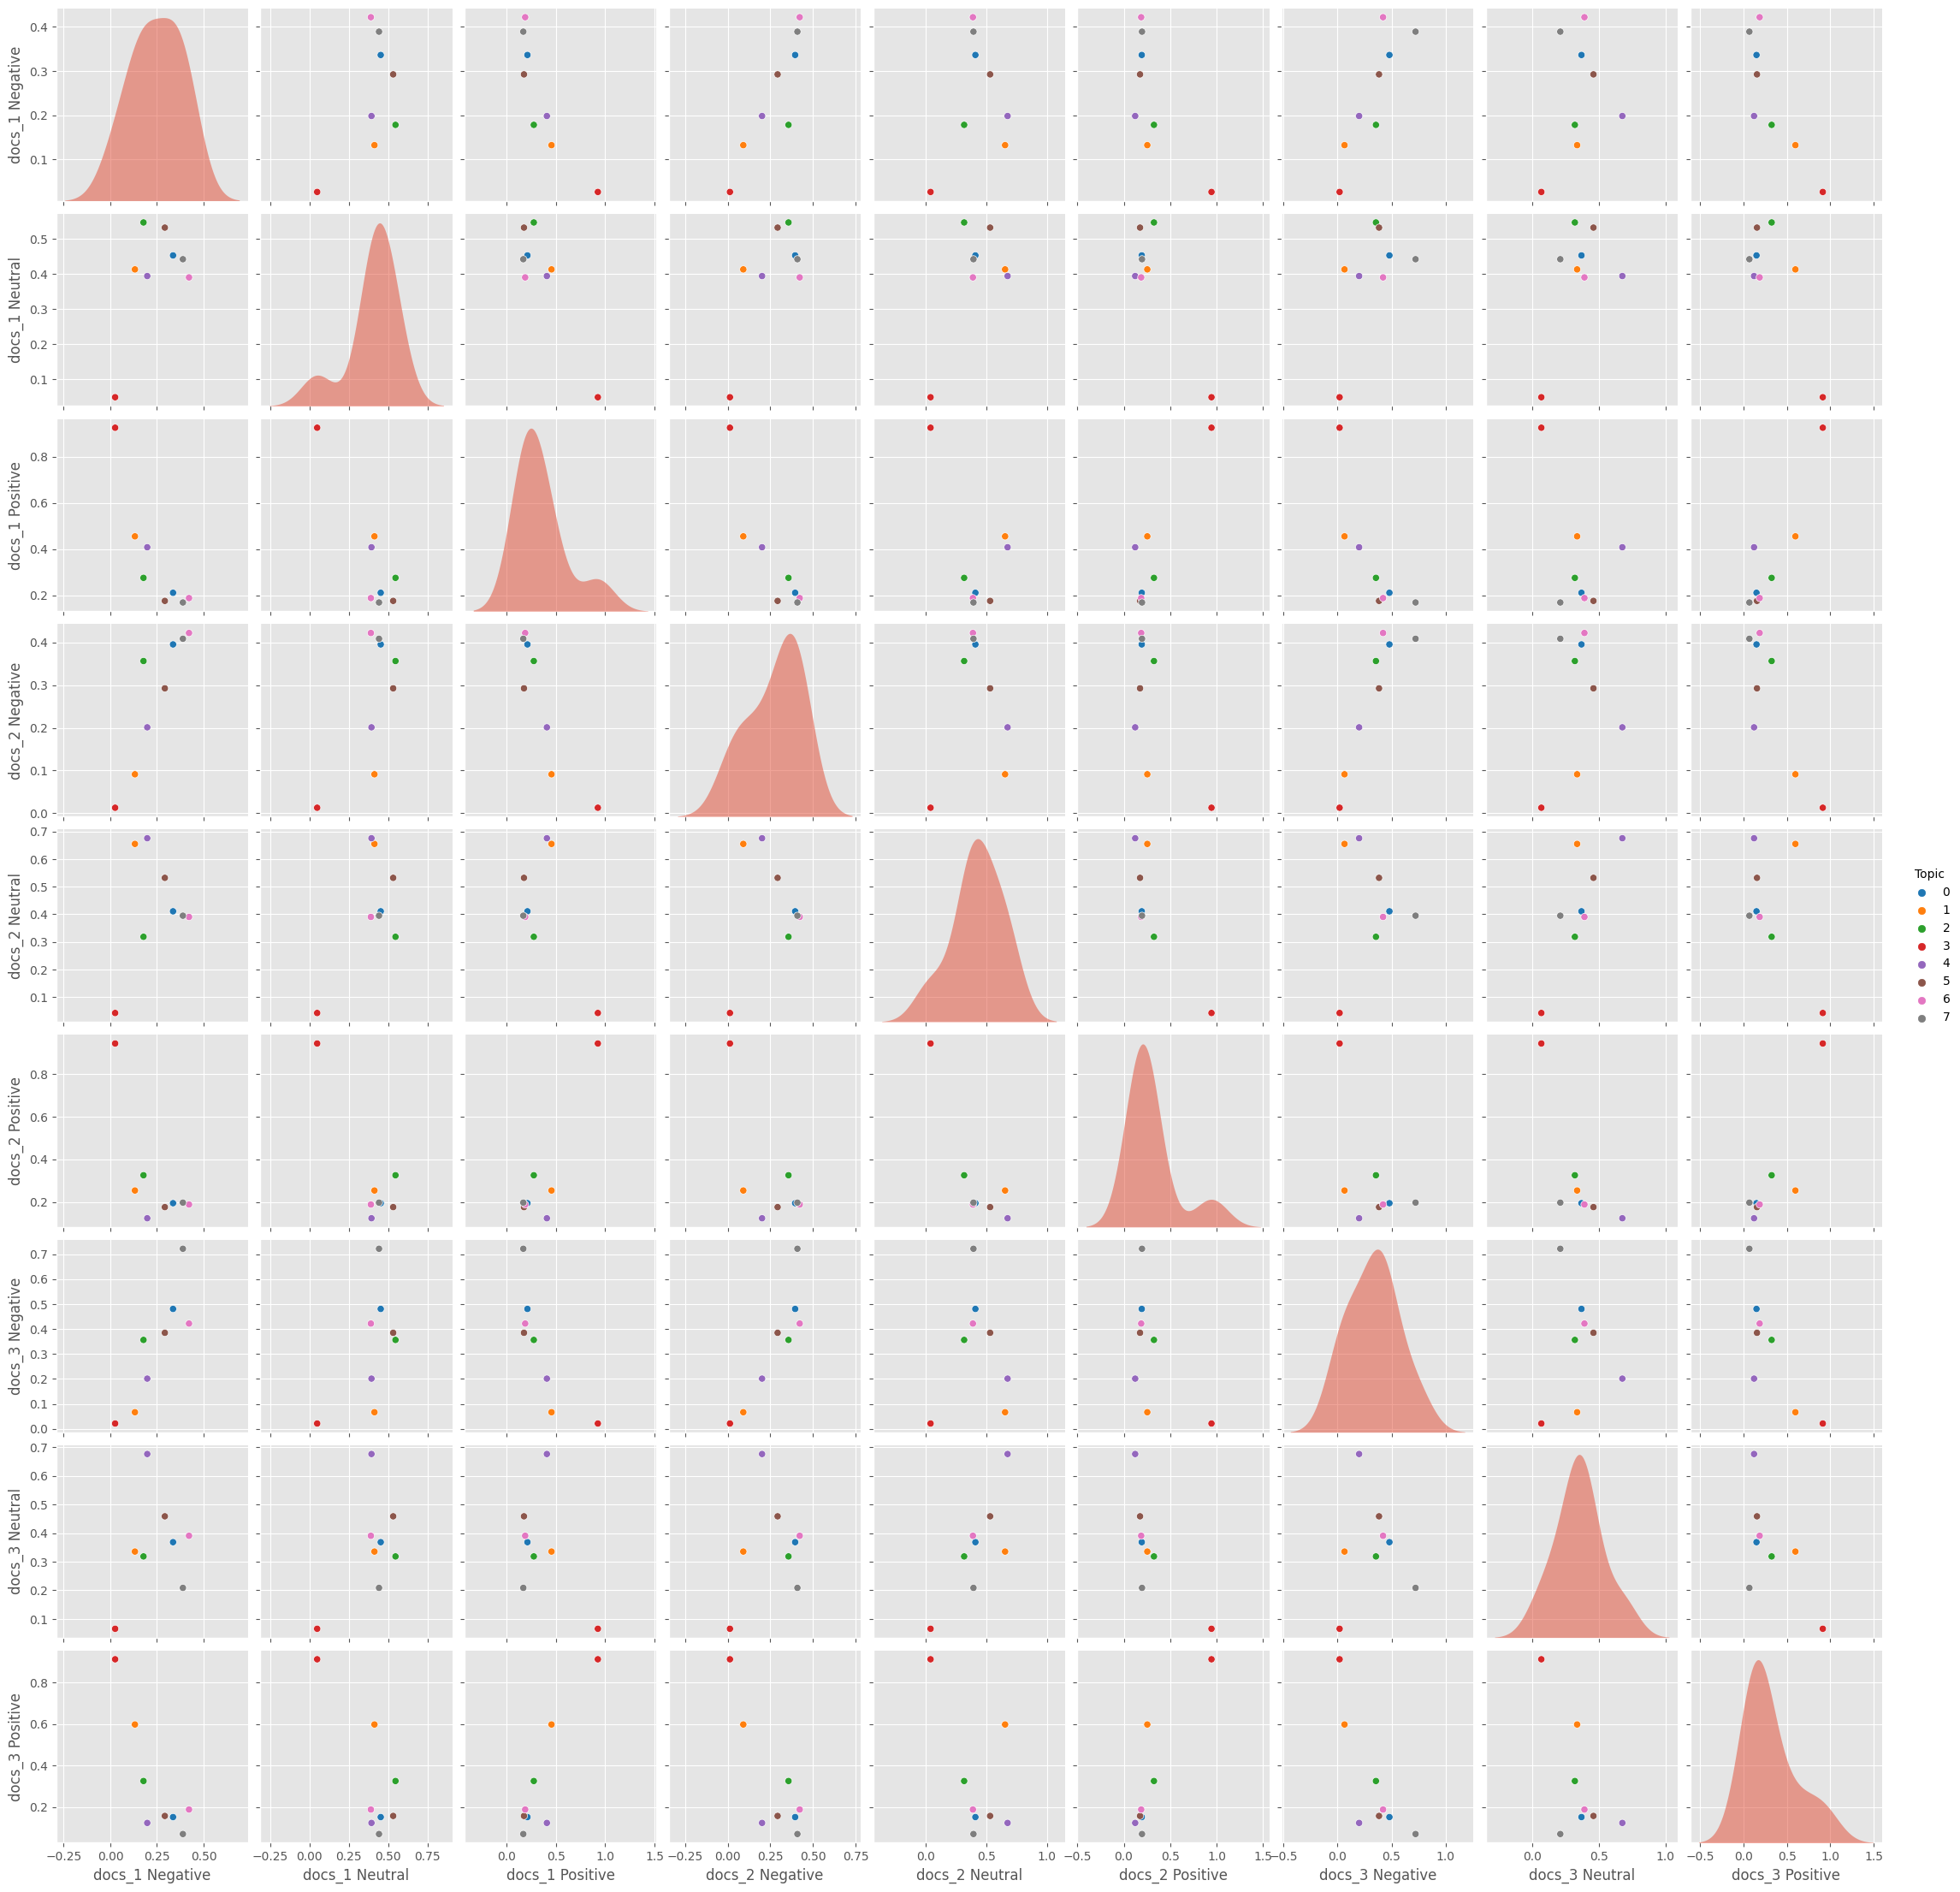

In [48]:
pair_viz = df.drop(columns=['Count']) #for this viz we don't need the count label (take also off compound)

pairplot = sns.pairplot(data = pair_viz, hue='Topic', palette='tab10')
# Add a kdeplot to the diagonal subplots for a more interesting visualization
for ax in pairplot.diag_axes:
    sns.kdeplot(pair_viz[ax.get_xlabel()], ax=ax, fill=True, alpha=.5,linewidth=0) #cambiare i colori
plt.show()

## POS_TAGGING and Dependency visualizer

In [53]:
import spacy

nlp = spacy.load("xx_sent_ud_sm")#multilingual tokeniser


df = pd.read_csv(r'/kaggle/working/sentiment_output.csv', encoding="utf-8")

# Define a function to tokenize text using spaCy
def tokenize(text):
    if isinstance(text, str):
        doc = nlp(text)
        return [token.text for token in doc]
    return []

# Define a function to split text into sentences using spaCy
def split_sentences(text):
    if isinstance(text, str):
        doc = nlp(text)
        return [sent.text for sent in doc.sents]
    return []

# Apply the sentence splitting function to the new columns
df['docs_1_sentences'] = df['docs_1'].apply(split_sentences)
df['docs_2_sentences'] = df['docs_2'].apply(split_sentences)
df['docs_3_sentences'] = df['docs_3'].apply(split_sentences)

df.to_csv(r'/kaggle/working/sentences.csv', index=False)

df.head(11)

,Name,Labels,Count,Keywords,Topic,docs_1,docs_2,docs_3,docs_1 Negative,docs_1 Neutral,docs_1 Positive,docs_2 Negative,docs_2 Neutral,docs_2 Positive,docs_3 Negative,docs_3 Neutral,docs_3 Positive,docs_1_sentences,docs_2_sentences,docs_3_sentences
0,-1_the_it_to_you,"['""Card Game Design and Symbolism""']",5706,"['symbols', 'cards', 'text', 'game', 'editing'...",0,This is for everyone Just how you didn’t expec...,#4 is definitely one of the biggest criticisms...,"On adding symbols to the card, I disagree that...",0.336335,0.453042,0.210622,0.395210,0.410928,0.193862,0.480630,0.368161,0.151209,[This is for everyone Just how you didn’t expe...,"[#, 4 is definitely one of the biggest critici...","[On adding symbols to the card, I disagree tha..."
1,Family and Games,['Family bonding through Uno'],526,"['playing', 'game', 'played', 'games', 'play',...",1,"I'm a game developer, and I realized that my i...",How me and my friends play uno,I like the card game of uno,0.131951,0.413219,0.454830,0.091166,0.655290,0.253545,0.066423,0.335387,0.598190,"[I'm a game developer, and I realized that my ...",[How me and my friends play uno],[I like the card game of uno]
2,Rules of Games,"['""Rule breaches in game design""']",139,"['symbols', 'rules', 'games', 'confusing', 'pl...",2,You should be careful with the symbols (Golden...,Thanks for this list! Soooo many games don't d...,Thanks for this list! Soooo many games don't d...,0.177935,0.546884,0.275180,0.356302,0.318396,0.325302,0.356302,0.318396,0.325302,[You should be careful with the symbols (Golde...,"[Thanks for this list!, Soooo many games don't...","[Thanks for this list!, Soooo many games don't..."
3,Games Collection,"['""Grande Jack Collection""']",123,"['collezione', 'collection', 'bellissima', 'gr...",3,che bella collezione,Che bella collezione 😍😍,Che collezione 💪💪💪,0.025867,0.049133,0.924999,0.012890,0.042108,0.945001,0.021147,0.065871,0.912982,[che bella collezione],[Che bella collezione 😍😍],[Che collezione 💪💪💪]
4,Traditional Games,['Card games and techniques'],77,"['playing', 'games', 'game', 'played', 'play',...",4,"​@@TheHistoryGuyChannel ​Yah, as I recall, the...","@@alymbouras it doesn't really matter, the imp...","@@alymbouras it doesn't really matter, the imp...",0.198036,0.394246,0.407718,0.201143,0.675885,0.122972,0.201143,0.675885,0.122972,"[​@@TheHistoryGuyChannel ​Yah, as I recall, th...","[@@alymbouras it doesn't really matter, the im...","[@@alymbouras it doesn't really matter, the im..."
5,Memories,['Facts are appreciated and shared'],433,"['facts', 'honestly', 'interessante', 'interes...",5,Facts,Facts,FACTS,0.292365,0.532229,0.175406,0.292365,0.532229,0.175406,0.384868,0.458438,0.156694,[Facts],[Facts],[FACTS]
6,5_fr_bruh_frr_bruhv,"['""Bruh"" language and its use']",307,"['fr', 'frr', 'ft', 'frrr', 'fe', 'hi', 'fcf',...",6,Fr,Fr,Fr,0.421967,0.390429,0.187604,0.421967,0.390429,0.187604,0.421967,0.390429,0.187604,[Fr],[Fr],[Fr]
7,6_the_to_of_and,['Card games without indexes'],7791,"['playing', 'cards', 'game', 'card', 'games', ...",7,It seems that every country has a card game of...,One thing most cards are missing (which is wei...,@@StefanLopuszanski I have looked you up and y...,0.389189,0.442216,0.168595,0.408469,0.394997,0.196534,0.721924,0.208678,0.069397,[It seems that every country has a card game o...,[One thing most cards are missing (which is we...,[@@StefanLopuszanski I have looked you up and ...
